# Group 1 - Network Analysis

### Data Science at ITU

## Project name

Group/contact:
- Martin Kirkegaard
- Florian Micliuc (flmi@itu.dk)
- Markus Kristoffer Sibbesen
- Constantin-Bogdan Craciun
- Josephine Tia Højer Holst
- Jacob Andreas Sneding Rohde

Key points about our network:
- directed graph (weighted) (we made it weighted)
- unipartite
- cyclic
- one single strongly connected component (we made it)
- no self-loops (we removed self-loops)

Done so far:
- Description of the network
- Filtering/Cleaning of the datasets
- Statistics
- Visuallysation
- Si-Model
- Communities
- link prediction (not yet)

Questions:
- the direction
- research question
- discussion
- conclusion

Ideas:
- spreading disease or whatever
- crucial nodes/edges
- max flow
- bridges
- Si-model(some kind)

# Project outline (1)

1. Data description - how did we construct the graph? (preprocessing, motivate choices for nodes/edges/weights)
2. Basic properties and statistics
3. **RQ: How does different measures of sturctural importance influence the spread of a potential disease in the SI(/SIR) model? - and which are most impprtant for preventing / stopping the spread?**
4. Propose disease model SI(/SIR): Justify choice of model. Justify edge weight = passengers.
5. Propose candidate metrics for measurinc structural importance of nodes (airport) /edges (routes).

_E.g. degree centrality, bridges/borders/communities, degree, others?_

6. Run different simulations by removing/starting at different nodes/edges. Alter network according to some importance criteria (specify above) and report the consequences / effect.

_What should our measure of 'success' be (e.g. amount of 'steps')?_

7. Discuss the effect on spread with different alterations.
8. Conclude on discussion

### Important assumptions / simplifications to remember
- Accumulated values/weights over the entire year 2013. Assuming a uniform distribution of passengers?
- In our networ, nodes consist of airports - not individuals. Therefore, the mechanism of infecting a node is highly simplified. An entire airport is wither infected or it is not.
- For simplification, the entire network is considered in isolation. This means that infection spreading from airport to airport through other transportation types are not considered.

# Imports

In [6]:
import pandas as pd
import numpy as np
from collections import Counter
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import folium
#import geojson
#import geopandas
import mplleaflet
from folium.plugins import HeatMap
import json
from networkx.algorithms.community.centrality import girvan_newman

# Functions

In [7]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [9]:
def plot_degree_dist_hist(G):
    degrees = [G.out_degree(n) for n in G.nodes()]
    fig = plt.figure(figsize = (10,10))
    plt.hist(degrees, bins = 30,color = 'gray',edgecolor = 'black')
    plt.xlabel('Node out-degree',fontsize = 15)
    plt.ylabel('No. of nodes',fontsize = 15)
    plt.title('Histogram of out-degree',fontsize = 15);
    plt.show()

In [10]:
def one_tick(G, infected_set, beta):
    add_to_set = set()
    for node in infected_set:
        sum_weight_root = np.sqrt(sum([G[node][i]['weight'] for i in G.neighbors(node)]) + 0.001)
        for neighbor in G.neighbors(node):
            if beta * ((G[node][neighbor]['weight'] + 1) / sum_weight_root) > random.random():
                add_to_set.add(neighbor)
    return add_to_set

In [11]:
def inverse_squareroot(x,sum_var):
    return (x + 1)/np.sqrt(sum_var)
def exp_func(x):
    return 0.0682*(x**0.4729)

# Classes

In [12]:
random.random()

0.994157990221247

In [13]:

class Simulation:
    
    def __init__(self, edgelist):
        self.Graph = nx.DiGraph()
        self.Graph.add_edges_from(edgelist)
        for node in self.Graph.nodes():
            self.Graph.nodes[node]['sum_weight_root'] = np.sqrt(sum([self.Graph[node][i]['weight'] for i in self.Graph.neighbors(node)]) + 0.001)

    def one_tick(self, infected):
        '''
        simulates one tick, taking a beta value and a set of already infected nodes
        returns a new set of infected nodes
        '''
        
        add_to_set = set()
        
        for node in infected:

            for neighbor in self.Graph.neighbors(node):
                if neighbor not in infected:
                    passengers = self.Graph[node][neighbor]['weight'] + 1
                    sum_var = self.Graph.nodes[node]['sum_weight_root']
                    x = inverse_squareroot(passengers, sum_var)
                    prob = exp_func(x)
                    if prob > random.randint(0,100):
                        add_to_set.add(neighbor)
                    
        return infected | add_to_set
    
    def simulate_amount_of_ticks(self, outset='random', ticks=1):
        '''
        simulates specified amount of ticks, taking a beta value, an amount of ticks 
        and an initial outset of infected nodes (defaults a random node)
        returns a list of sets, each element being the set of infected nodes for each tick
        '''
        
        if outset == 'random':
            infected_list = [{random.choice(list(self.Graph.nodes()))}]
        else:
            infected_list = [outset]
        
        for _ in range(ticks):
            infected_list.append(self.one_tick(infected_list[-1]))
    
        return infected_list
    
    def simulate_until_threshold(self, threshold, outset='random', limit=500):
        '''
        simulates until a certain number of nodes are infected, taking a beta value,
        a threshold and a limit for amount of ticks
        returns the amount of ticks to get to threshold
        '''
        
        if outset == 'random':
            infected = {random.choice(list(self.Graph.nodes()))}
        else:
            infected = outset
        
        for i in range(limit):
            infected = self.one_tick(infected)
            
            if len(infected) >= threshold:
                return i
    
        return limit
    
    def threshold_trials(self, threshold, outset='random', limit=500, trials=10):
        '''
        simulates a number of trials using the threshold method,
        returning a list of the amount of ticks to reach threshold
        '''
        li = []
        percent = 0.1
        for i in range(trials):
            n = trials * percent
            if i > n:
                #print(int(percent * 100),"% done")
                percent += 0.1
            li.append(self.simulate_until_threshold(threshold=threshold, outset=outset, limit=limit))
            
        return li

# I. Data filtering and cleaning

Loading the coordinates data

In [14]:
coords = pd.read_json('../Data/total.json')

In [15]:
coords = coords.T.reset_index()

In [16]:
coords_origin = coords.rename(columns = {'index':'ORIGIN',0:'longitude_origin',1:'latitude_origin'})
coords_dest = coords.rename(columns = {'index':'DEST',0:'longitude_dest',1:'latitude_dest'})

Loading the main dataset and merging everything into 'data_merged'

In [17]:
data_filtered = pd.read_csv('../Data/final_cool_dataset.csv',delimiter = ',')

In [18]:
data_filtered_coord = pd.merge(data_filtered,coords_origin, on = ['ORIGIN'])
data_filtered_coord = pd.merge(data_filtered_coord,coords_dest, on = ["DEST"])

In [19]:
data_filtered.columns

Index(['ORIGIN', 'DEST', 'PAYLOAD', 'DISTANCE', 'SEATS', 'PASSENGERS',
       'DEPARTURES_PERFORMED', 'CARRIER_NAME', 'ORIGIN_AIRPORT_ID',
       'DEST_AIRPORT_ID', 'ORIGIN_NAME', 'DEST_NAME'],
      dtype='object')

# II. Network generation

In [20]:
graph = data_filtered_coord[['ORIGIN','DEST']]

In [21]:
G = nx.DiGraph()

In [22]:
for i,j in zip(graph['ORIGIN'],graph['DEST']):
    G.add_edge(i,j)

In [23]:
#plt.figure(figsize=(300, 200))
#nx.draw(G, with_labels=True,node_size = 10000,font_color = 'white',node_color = 'gray')

# III. Statistical analysis 

Here we find that the diameter of the graph is 7
This means that you can get from any airport to any airport in at most 7 steps. 
The longest shortest path is 7

In [24]:
nx.diameter(G)

7

This is the average shortest path of the network. Meaning on average if you pick two nodes at random the distance is a path with the length of 3

In [25]:
nx.average_shortest_path_length(G)

3.1020730730730732

### Finding the longest shortest paths

In [26]:
li = []
for node in G.nodes():
    start_end_nodes = [(node, k) for k,v in nx.shortest_path_length(G, node).items() if v == 7]
    if start_end_nodes != []:
        li.append(start_end_nodes)

In [27]:
with open("../Data/total.json", "r") as file:
    airport_lookup_table = json.load(file)

In [28]:
airport_lookup_table

{'04A': [31.7363, -86.262497],
 '06A': [32.460499, -85.680002],
 '08A': [32.5294, -86.328201],
 '1B1': [42.2913017273, -73.7102966309],
 '1G4': [35.985787, -113.817072],
 '1N7': [40.9710998535, -74.99749755859999],
 '6B0': [43.9847984314, -73.09590148929999],
 '7AK': [54.14459, -165.604332],
 'A14': [58.9065, -157.714],
 'A26': [41.18600082397461, -120.9520034790039],
 'A27': [59.439335, -151.720805],
 'A29': [57.052101135253906, -135.3459930419922],
 'A40': [71.057926, -154.73912],
 'A63': [59.07559967041, -160.27299499512],
 'ABE': [40.651773, -75.442797],
 'ABI': [32.4113006592, -99.68190002440001],
 'ABL': [67.1, -157.81666666666666],
 'ABQ': [35.040199, -106.609001],
 'ABR': [45.449100494384766, -98.42179870605469],
 'ABY': [31.532946, -84.196215],
 'ACK': [41.25310135, -70.06020355],
 'ACT': [31.611299514770508, -97.23049926757812],
 'ACV': [40.978101, -124.109],
 'ACY': [39.45759963989258, -74.57720184326172],
 'ADK': [51.883564, -176.642783],
 'ADQ': [57.75, -152.4940033],
 'AD

In [29]:
routes = dict()
coord = dict()
for elm in li:
    from_ = elm[0][0]
    #routes[from_] = []
    routes_dict = dict()
    coord_dict = dict()
    for i in elm:
        to_ = i[1]
        shortest_path = nx.shortest_path(G, from_, to_)
        
        routes_dict[to_] = shortest_path
        coord_dict[to_] = [airport_lookup_table[x] for x in shortest_path]
        #airport_name_coordinates
        #coord_dict[to_] = [airport_name_coordinates(x) for x in shortest_path]
    coord[from_] = coord_dict
    routes[from_] = routes_dict

In [30]:
from_ = []
dest_ = []
coordinates = []
path = []
for elm in coord.items():
    fr = elm[0]
    
    for i in elm[1].keys():
        dest_.append(i)
        path.append(routes[fr][i])
        from_.append(fr)
    for i in elm[1].values():
        coordinates.append(i)

In [31]:
d = {"from": from_, "dest": dest_, "path": path, "coordinates": coordinates}
df_paths = pd.DataFrame(data=d)
#df_paths.to_csv('../Data/to_florian_dataframe_longest_paths.csv', index=False)

### Centrality

In graph theory and network analysis, indicators of centrality assign numbers or rankings to nodes within a graph corresponding to their network position. Applications include identifying the most influential person(s) in a social network,

In [32]:
sorted_degree_centrality = sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)
sorted_degree_centrality = [x[0] for x in sorted_degree_centrality[0:20]]
#These are the most "central" nodes in the graph
sorted_degree_centrality

['ATL',
 'MSP',
 'DEN',
 'ORD',
 'DFW',
 'ANC',
 'MEM',
 'DTW',
 'IAH',
 'LAS',
 'LAX',
 'SDF',
 'IAD',
 'YIP',
 'EWR',
 'CLT',
 'IND',
 'BUR',
 'BWI',
 'MIA']

### Clustering coefficient

Clustering coefficient is how many of a nodes neighboors are connected. If the clustering coefficient of a node is 0.5, it means half the nodes neighbors are connected

In [33]:
#The average clustering coefficient of the network is 0.56
nx.average_clustering(G)

0.5732241413139196

In [34]:
#Clustering for nodes
clustering = nx.clustering(G)
clustering_sorted = sorted(clustering.items(), key=lambda x: x[1], reverse=True)
clustering_sorted

[('DIO', 1.0),
 ('KPC', 1.0),
 ('MOS', 1.0),
 ('OHC', 1.0),
 ('04A', 1.0),
 ('A26', 1.0),
 ('A63', 1.0),
 ('AK5', 1.0),
 ('CKX', 1.0),
 ('CZN', 1.0),
 ('HGZ', 1.0),
 ('LIV', 1.0),
 ('ORT', 1.0),
 ('UUK', 1.0),
 ('7AK', 1.0),
 ('DRF', 1.0),
 ('MDO', 1.0),
 ('MXY', 1.0),
 ('NCN', 1.0),
 ('PUO', 1.0),
 ('TEK', 1.0),
 ('A29', 1.0),
 ('BFB', 1.0),
 ('DGB', 1.0),
 ('SKJ', 1.0),
 ('08A', 1.0),
 ('SOV', 1.0),
 ('GUS', 1.0),
 ('MTP', 1.0),
 ('ELD', 1.0),
 ('BRL', 1.0),
 ('DEC', 1.0),
 ('VAD', 1.0),
 ('CWF', 1.0),
 ('BWD', 1.0),
 ('HSH', 1.0),
 ('SCH', 1.0),
 ('CLD', 1.0),
 ('HIO', 1.0),
 ('LVK', 1.0),
 ('LWC', 1.0),
 ('NEW', 1.0),
 ('RAC', 1.0),
 ('SBD', 1.0),
 ('SCF', 1.0),
 ('MZJ', 1.0),
 ('VCT', 1.0),
 ('GBD', 1.0),
 ('MCK', 1.0),
 ('SVC', 1.0),
 ('ALW', 1.0),
 ('CLM', 1.0),
 ('MVW', 1.0),
 ('WYS', 1.0),
 ('DVN', 1.0),
 ('GSH', 1.0),
 ('IKV', 1.0),
 ('MVN', 1.0),
 ('OTM', 1.0),
 ('SGH', 1.0),
 ('AXV', 1.0),
 ('LKK', 1.0),
 ('RBH', 1.0),
 ('PCA', 1.0),
 ('KCR', 1.0),
 ('MDR', 1.0),
 ('WOW', 1

In [35]:
#Clustering coefficient plottet

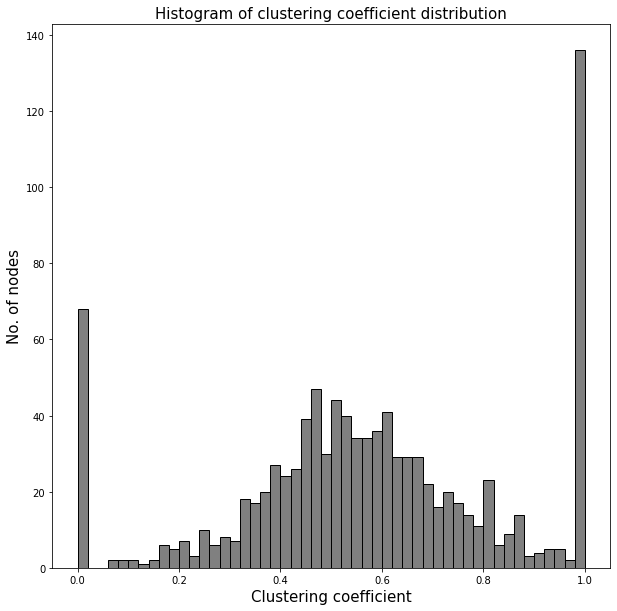

In [36]:
t = [x[1] for x in clustering_sorted]
fig = plt.figure(figsize = (10,10))
plt.hist(t, bins = 50,color = 'gray',edgecolor = 'black')
plt.xlabel('Clustering coefficient',fontsize = 15)
plt.ylabel('No. of nodes',fontsize = 15)
plt.title('Histogram of clustering coefficient distribution',fontsize = 15);

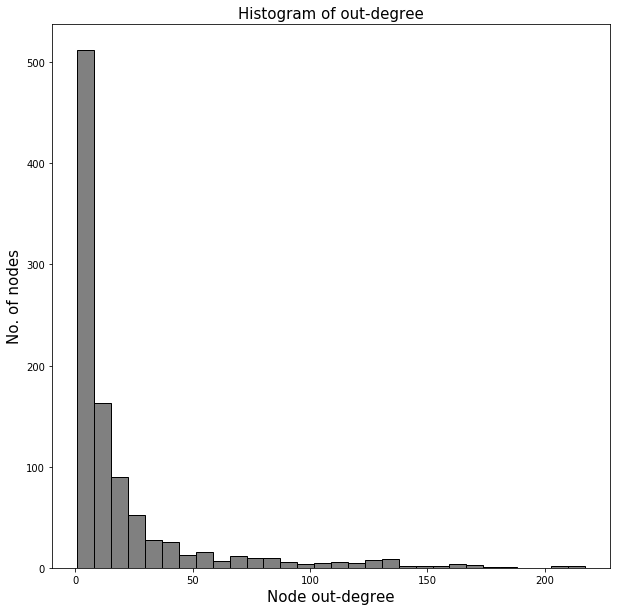

In [37]:
plot_degree_dist_hist(G)

NameError: name 'x' is not defined

In [42]:
def helper(li, x):
    return sum(i > x for i in li)

In [43]:
def plot_degree_dist_log(G):
    degrees = [G.out_degree(n) for n in G.nodes()]
    
    fig = plt.figure(figsize = (10,10))
    degrees = sorted(degrees, reverse= True)
    
    temp = []
    for i in range(max(degrees)):
        temp.append(helper(degrees,i))
    
    plt.loglog(temp,color = 'gray')
    plt.title('Out-degree distribution using a loglog plot',fontsize = 15)
    plt.show()

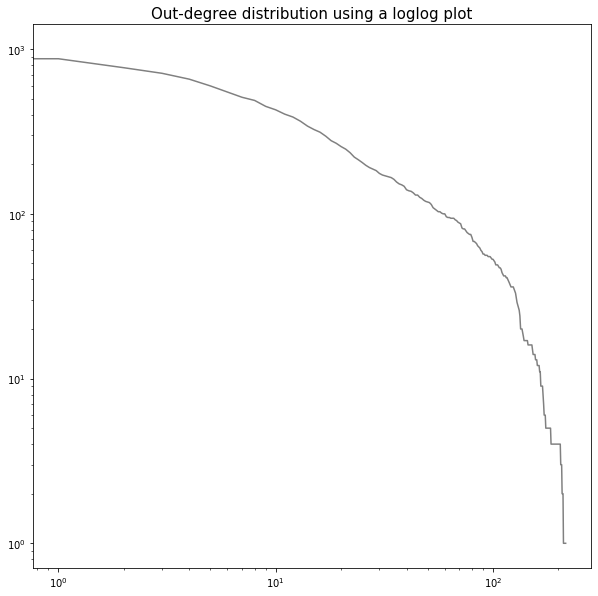

In [44]:
#Degree distribution using a loglog plot.
#If it were to be a straight line it would follow a power law, since it is not a straight line, it does not follow a power law
plot_degree_dist_log(G)

### Assortative analysis

In [ ]:
#nx.degree_assortativity_coefficient(G)

In [ ]:
#nx.average_neighbor_degree(G)

In [ ]:
#homophilu, Configuration Network 

# IV. Possible measures of importance / centrality

### Generating a weighted graph

In [ ]:
edges = [(row['ORIGIN'], row['DEST'], {'weight': row['PASSENGERS']}) for _, row in data_filtered.iterrows()]

In [ ]:
G_weighted = nx.DiGraph()
G_weighted.add_edges_from(edges)

## A) Node metrics
### _Degree-based_: Degree Centrality
The number of links incident upon a node. The degree can be interpreted in terms of the immediate risk of a node for catching whatever is flowing through the network (such as a virus, or some information). Since we have a directed network, we should define both an indegree and outdegree.

Basicly just the degree 

In [ ]:
# Computing in-degree for nodes in G
sorted_in_degree = sorted(nx.in_degree_centrality(G_weighted).items(), key=lambda x: x[1], reverse=True)

# Selecting 10 highest ranking nodes
sorted_in_degree[0:10]

In [ ]:
# Computing out-degree for all nodes in G
sorted_out_degree = sorted(nx.out_degree_centrality(G_weighted).items(), key=lambda x: x[1], reverse=True)

# Selecting 10 highest ranking nodes
sorted_out_degree[:10]

### _Degree-based_: Eigenvector centrailty (eigencentrality)
 - Lecture 2
 
Assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.

Using the adjacency matrix to find eigenvector centrality: In general, there will be many different eigenvalues 
$\lambda$  for which a non-zero eigenvector solution exists. Since the entries in the adjacency matrix are non-negative, there is a unique largest eigenvalue, which is real and positive, by the Perron–Frobenius theorem. This greatest eigenvalue results in the desired centrality measure. The $v$'th component of the related eigenvector then gives the relative centrality score of the vertex $v$ in the network.

Can we use the eigenvectors to discover 'bridges' between clusters?

For directed graphs, we can use the Eigen Vector Centrality to evaluate the “importance” of a node (based on the out-degree Eigen Vector) and the “prestige” of a node (through the in-degree Eigen Vector).
- A node is considered to be more important if it has out-going links to nodes that in turn have a larger out-degree (i.e., more out-going links).
- A node is considered to have a higher “prestige”, if it has in-coming links from nodes that themselves have a larger in-degree (i.e., more in-coming links).

**OBS**: Is it problematic for directed graphs?? Eigenvector centrality will not take zero in-degree nodes into account in directed graphs. 
_Example_: A new research paper is published and it references a handful of existing papers. It would not contribute to any of those referenced papers in this citation network because it is not cited by any other papers and has zero eigenvector centrality.

Basicly this is the un-normalized eigenvectors which the pagerank is made out of

In [ ]:
# Computing in-edges eigenvector centrality for all nodes in G
sorted_eigenvector_in = sorted(nx.eigenvector_centrality(G_weighted, weight='weights').items(), 
                            key=lambda x: x[1], reverse=True)

# Selecting 10 highest ranking nodes
sorted_eigenvector_in[:10]

In [ ]:
# Computing out-edges eigenvector centrality for all nodes in G
sorted_eigenvector_out = sorted(nx.eigenvector_centrality(G_weighted.reverse(), weight='weights').items(), 
                            key=lambda x: x[1], reverse=True) # G.reverse() = out-edges distance, directions reversed

# Selecting 10 highest ranking nodes
sorted_eigenvector_out[:10]

### _Shortest-path-based_: Closeness centrailty
Is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. The more central a node is, the closer it is to all other nodes.

We must consider taking distances _from_ or _to_ all other nodes, as it can produce very different results in directed graphs (e.g. an airport can have a high closeness centrality from outgoing routes, but low closeness centrality from incoming routes).

Closeness centrality indicates how close a node is to all other nodes in the network. It is calculated as the average of the shortest path length from the node to every other node in the network. 

st is the number of shortest paths from node s to t.
st(v) is the amount of those shortest paths going through the node v.
We then normalize it using our normalize function
$\frac{g(v)-min(g)}{max(g)-min(g)}$


g(v) = $\sum_{s\neq v \neq t}(\frac{\sigma_{st}(v)}{\sigma st})$


In [ ]:
# Computing inward distance for all nodes, using edge weights
sorted_closeness_centrality_in = sorted(nx.closeness_centrality(G_weighted, distance='weights', wf_improved=False).items(), 
                                      key=lambda x: x[1], reverse=True) # wf=True only for disconnected graphs

# Selecting 10 highest ranking nodes
sorted_closeness_centrality_in[:10]

In [ ]:
# Computing outward distance for all nodes, using edge weights
sorted_closeness_centrality_out = sorted(nx.closeness_centrality(G_weighted.reverse(), distance='weights', wf_improved=False).items(), 
                                      key=lambda x: x[1], reverse=True) # G.reverse() = outward distance, directions reversed

# Selecting 10 highest ranking nodes
sorted_closeness_centrality_out[:10]

### _Shortest-path-based_: Betweenness centrailty (node)  
- Lecture 3

Quantifies the number of times a _node_ acts as a bridge along the shortest path between two other nodes. In his conception, nodes that have a high probability to occur on a randomly chosen shortest path between two randomly chosen vertices have a high betweenness. The measure is related to a network's connectivity - high betweenness nodes have the potential to disconnect graphs if removed.

(Find out which algorithm to use for directed, weighted graph).

In [ ]:
#

Amount of times a node is in a shortest path

In [ ]:
# Remove edges with weight zero (or use graph with +1 values, Markus)
G_nonzero = G_weighted.copy()
to_remove = [(a,b) for a, b, attrs in G_weighted.edges(data=True) if attrs["weight"] <= 0.0]
G_nonzero.remove_edges_from(to_remove)

In [ ]:
# Computing betweenness centrality for all nodes in G
betweenness = sorted(nx.betweenness_centrality(G_nonzero, normalized=True, weight='weights', endpoints=False, seed=0).items(), 
               key=lambda x: x[1], reverse=True) # set seed to make reproducible 

# Selecting 10 highest ranking nodes
betweenness[:10]

## B) Edge measures 

#### Betweenness centrailty (edge)
The number of the shortest paths to go through an _edge_ in a graph or network (Girvan and Newman). An edge with a high edge betweenness centrality score represents a bridge-like connector between two parts of a network (as with node betweenness centrailty), where the removal may affect the 'communication' between many pairs of nodes through the shortest paths between them.

In [ ]:
# Computing betweenness centrality for all edges in G
edge_betweenness = [(k, v) for k, v in sorted(nx.edge_betweenness_centrality(G_weighted, normalized=True, weight='weights', seed=0).items(), key=lambda item: item[1], reverse=True)]

# Selecting 10 highest ranking edges
edge_betweenness[:10]

In [ ]:
sorted_page_rank = sorted(nx.pagerank(G_weighted).items(),key = lambda x: x[1], reverse = True)

# Community discovery

### CD: Girvan-Newman
Communities are discovered by iteratively removing the "most valuable" edges of the graph. This value is based on the edge betweenness centrality (the number of shortest paths that pass through an edge)

In [ ]:
#G_comm = nx.DiGraph()

In [ ]:
#communities = girvan_newman(G)

In [ ]:
#node_groups = [list(com) for com in next(communities)]

In [ ]:
#print('no. of communities:', len(node_groups))

In [ ]:
#node_groups

# V. Map visualization

In [ ]:
mask = ~data_filtered_coord['ORIGIN'].isin(['SYA','TNK','RBN']) & ~data_filtered_coord['DEST'].isin(['SYA','TNK','RBN'])

In [ ]:
x_zip = list(zip(data_filtered_coord[mask]['latitude_origin'],data_filtered_coord[mask]['latitude_dest']))
y_zip = list(zip(data_filtered_coord[mask]['longitude_origin'],data_filtered_coord[mask]['longitude_dest']))

In [ ]:
coords_name_df = pd.DataFrame()
coords_name_df['ORIGIN'] = data_filtered_coord[mask]['ORIGIN']
coords_name_df['COORDS'] = list(zip(data_filtered_coord[mask]['latitude_origin'],data_filtered_coord[mask]['longitude_origin']))

In [ ]:
coords_name_df = coords_name_df.drop_duplicates()

Using matplotlib and mplleaflet(if you install mplleaflet you need to change something in the source code so remind me to tell you how)

In [ ]:
norm_pass = NormalizeData(data_filtered['PASSENGERS'])
pass_count = []
for i in norm_pass:
    if i < 0.95:
        i+= 0.05
    pass_count.append(i)

In [ ]:
fig,ax = plt.subplots(figsize = (125,75))
for i, (x,y) in enumerate(zip(x_zip,y_zip)):
    ax.plot(x,y,'grey',alpha = pass_count[i])
ax.scatter(x_zip,y_zip)
plt.show()

using networkx

In [ ]:
G_coord = nx.DiGraph()

In [ ]:
pos = dict()
for i,j in zip(coords_name_df['ORIGIN'],coords_name_df['COORDS']):
    pos[i] = (j[0],j[1])
    G_coord.add_node(i)

In [ ]:
for i,j in zip(data_filtered_coord[mask]['ORIGIN'],data_filtered_coord[mask]['DEST']):
    G_coord.add_edge(i,j,weight = pass_count)

In [ ]:
nx.is_strongly_connected(G_coord)

In [ ]:
color_map = []
for node in G_coord:
    if node in node_groups[0]:
        color_map.append('blue')
    elif node in node_groups[1]:
        color_map.append('red')
    else: 
        color_map.append('green')  
#nx.draw(G, node_color=color_map, with_labels=True)
#plt.show()

In [ ]:
fig,ax = plt.subplots(figsize = (125,75))
nx.draw(G_coord,pos = pos,ax = ax,with_labels = True,font_color = 'white',node_size = 5000,node_color = 'gray',edge_color = 'lightgray')
plt.show()

# VI. Research question

How we made the probability formula

We wanted to make a function where an airport 10 times the size of a smaller airport didn't have 10 times the chance of spreading compared to a smaller function.

As an example, if a small airport has two routes with 80 passengers and 20 passengers, a larger airport with 800 and 200 passengers isn't 10 times as likely to spread.


We have made a function which takes the proportions of the outgoing passengers aswell as the size of the airport into consideration. 
In short, this function punishes the size of the airport
$f(node) = \frac{node_{neighbor}[weight] +1}{\sqrt{\sum_{i \in node_{neighbors}}(node_{i}[weight])}} $

We used this function to generate a lot of data points. We then manually assigned a probability to each datapoint and made a powerlaw regression.
The output of the regression is this function
$P(infected) = 0.0682x^{0.4729}$

The simulation is done using a SI model, so either Susceptible $\textbf{S}$ or infected $\textbf{I}$ 

First step is choosing a node at random.
Earch tic S transitions into I with a probability explained above.

The stopping criteria is either 250 nodes infected or 500 tics has been reached.

## Discussion notes

Due to the very nature of how we have created our probability function it is biased
and not a true equation but only an approximation.
The underlying problem is the way we have designed it. Since we have made the model
from what we consider a "realistic" probability, it is very biased in our viewpoint. 

We unfortunately have not done any empirical studies or used real world data which shows the
an accurate representation of how a decease spreads exclusively throughout airports.
This heavily limits us and forces us to make assumptions.

However, when that is said the model has what we consider a "fair" 
balance between the clusters and remote airports. 


how we have removed the airports - what it means?

Another problem is the way we control the spread.
In our study we are simply removing the top 20 airports within a specific category.
In real life, it wouldn't be binary but more of a scale, so that the airports are 
opperating at a reduced capacity untill it shuts down.
Furthermore, once we remove an airport, the amount of people travaling isn't reduced,
so therefor some of the neighbooring weights should probably be updated to reflect this behavior



Other ways of controling spread

Another way could be reducing the capacity of the airport, which would result in
us deviding the outgoing passengers by some number, or you could make a "mask mandated"
which would reduce the likelyhood of the dicease spreading. 
These would also combat the proble
m of the graph no longer being stronly connected,
which in our model is not the case.
One could also simply remove some of the most "important" edges

### check if the removal of nodes contains the stronly connected 

### Infection simulations

In [ ]:
def get_prob(airport_code):
    subset = data_filtered[data_filtered["ORIGIN"] == airport_code]
    n = sum(subset["PASSENGERS"])
    for elm in subset.iterrows():
       # print(elm)
        dest = (elm[1]["DEST_NAME"])
        passengers = (elm[1]["PASSENGERS"]) + 1
        print("destination: ",dest)
        print("passengers: ",passengers)
        x = inverse_squareroot(passengers, n)
        prob = exp_func(x)
        print("sum: ",n)
        print("x: ",x)
        print("prob: ",prob)
        print("-"*75)
get_prob("LAX")

In [ ]:
sum(data_filtered[data_filtered["ORIGIN"] == "AIN"]["PASSENGERS"])

In [ ]:
data_filtered[data_filtered["ORIGIN"] == "AIN"]

In [ ]:
x = 0.05*(1/4803.0**0.5)
x

In [ ]:
(1-np.exp(-0.03*x))*100

In [71]:
edges = [(row['ORIGIN'], row['DEST'], {'weight': row['PASSENGERS']}) for _, row in data_filtered.iterrows()]

In [ ]:
obj_dict = {}
obj_dict["baseline_random"] = Simulation(edges)

In [ ]:
obj_dict = {}
obj_dict["baseline_nothing"] = Simulation(edges)
obj_dict["baseline_random"] = Simulation(edges)
#obj_dict["node_degree_centrality"] = Simulation(edges)
obj_dict["clustering_coefficient_high"] = Simulation(edges)
obj_dict["clustering_coefficient_low"] = Simulation(edges)
#obj_dict["node_degree"] = Simulation(edges)
obj_dict["closeness_centrality_in"] = Simulation(edges)
obj_dict["closeness_centrality_out"] = Simulation(edges)
obj_dict["betweenness_centrality"] = Simulation(edges)
obj_dict["degree_centrality_in"] = Simulation(edges)
obj_dict["degree_centrality_out"] = Simulation(edges)
obj_dict["eigenvector_in"] = Simulation(edges)
obj_dict["eigenvector_out"] = Simulation(edges)
obj_dict["pagerank"] = Simulation(edges)

In [ ]:
obj_dict["clustering_coefficient_high"].Graph.remove_nodes_from([x[0] for x in clustering_sorted][:20])

In [ ]:
obj_dict["clustering_coefficient_low"].Graph.remove_nodes_from([x[0] for x in clustering_sorted][-20:])

In [ ]:
obj_dict["baseline_random"].Graph.remove_nodes_from(random.choices(list(obj_dict["baseline_random"].Graph.nodes), k=20))

In [ ]:
#obj_dict["node_degree_centrality"].Graph.remove_nodes_from(sorted_degree_centrality)

In [ ]:
#obj_dict["node_degree"].Graph.remove_nodes_from([x[0] for x in sorted(obj_dict["node_degree"].Graph.degree(), key = lambda x: x[1],reverse= True)[:20]])

In [ ]:
obj_dict["closeness_centrality_in"].Graph.remove_nodes_from([x[0] for x in sorted_closeness_centrality_in][:20])

In [ ]:
obj_dict["closeness_centrality_out"].Graph.remove_nodes_from([x[0] for x in sorted_closeness_centrality_out][:20])

In [ ]:
obj_dict["betweenness_centrality"].Graph.remove_nodes_from([x[0] for x in betweenness][:20])

In [ ]:
obj_dict["degree_centrality_in"].Graph.remove_nodes_from([x[0] for x in sorted_in_degree][:20])

In [ ]:
obj_dict["degree_centrality_out"].Graph.remove_nodes_from([x[0] for x in sorted_out_degree][:20])

In [ ]:
obj_dict["eigenvector_in"].Graph.remove_nodes_from([x[0] for x in sorted_eigenvector_in][:20])

In [ ]:
obj_dict["eigenvector_out"].Graph.remove_nodes_from([x[0] for x in sorted_eigenvector_out][:20])

In [ ]:
obj_dict["pagerank"].Graph.remove_nodes_from([x[0] for x in sorted_page_rank][:20])

In [ ]:
obj_dict

In [ ]:
del obj_dict["baseline_random"]
del obj_dict["eigenvector_in"]
del obj_dict["eigenvector_out"]
#del obj_dict["node_degree_centrality"]
#del obj_dict["node_degree"]

In [ ]:
def total_simulation(dictionary, b):
    results_dict = {}
    for key, value in dictionary.items():
        print(key)
        simulation = value.threshold_trials(b,250, trials=500)
        results_dict[key] = simulation
    return results_dict
kat = total_simulation(obj_dict,0.005)

In [ ]:
def two_sample_bootstrap(x, y, samples=100):
    s_d = np.sqrt((np.var(x) / len(x)) + (np.var(y) / len(y)))
    t_d = (np.mean(x) - np.mean(y)) / s_d
    
    bootstraps = []
    for _ in range(samples):
        x_s = np.random.choice(x, size=len(x), replace=True)
        y_s = np.random.choice(y, size=len(y), replace=True)
        s_d_s = np.sqrt((np.var(x_s) / len(x_s)) + (np.var(y_s) / len(y_s)))
        t_d_s = ((np.mean(x_s) - np.mean(y_s)) - (np.mean(x) - np.mean(y))) / s_d_s
        bootstraps.append(t_d_s)
    
    return t_d, bootstraps

In [ ]:
t_d, bootstraps = two_sample_bootstrap(kat["node_degree_centrality"], kat["node_degree"], samples=10000)

In [ ]:
def mean_of_simulations(dictionary):
    for key in dictionary:
        if key not in {"baseline_nothing","baseline_random"}:
            #print(key)
            t_d, bootstraps = two_sample_bootstrap(dictionary["baseline_nothing"],dictionary[key] , samples=10000)
            print(key, round(t_d,2), [round(x,2) for x in np.quantile(bootstraps, (0.025, 0.975))])
    print("-"*100)
    for key, value in dictionary.items():
        if key not in {"baseline_random"}:
            print("The mean of ", key, int(np.average(value)))

In [ ]:
mean_of_simulations(kat)

In [ ]:
x = [exp_func(x) for x in range(300)]

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.title("Probability Function")
plt.xlabel("Normalized value")
plt.ylabel("Probability")
plt.plot(x,color = "gray");

In [ ]:
kat["pagerank"]

In [72]:
obj_baseline = Simulation(edges) 

In [ ]:
def f(x):
    return (x+1)/np.sqrt(2000000)

In [66]:
def p_r(f, i):
    print(i)
    return f

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.title("Probability Function")
plt.xlabel("Passengers")
plt.ylabel("Probability")
plt.plot([f(x) for x in range(10000)],color = "gray")

In [ ]:
var = [p_r(obj_baseline.threshold_trials(trials=i, threshold=250), i) for i in range(1,500,5)]

In [ ]:
x = [(np.mean(x)) for x in var]

In [ ]:
axes = plt.axes()
axes.set_ylim([0, 100])
plt.plot(x)

In [73]:
var2 = [p_r(obj_baseline.threshold_trials(trials=i, threshold=400), i) for i in range(1,500,5)]

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96
101
106
111
116
121
126
131
136
141
146
151
156
161
166
171
176
181
186
191
196
201
206
211
216
221
226
231
236
241
246
251
256
261
266
271
276
281
286
291
296
301
306
311
316
321
326
331
336
341
346
351
356
361
366
371
376
381
386
391
396
401
406
411
416
421
426
431
436
441
446
451
456
461
466
471
476
481
486
491
496


In [99]:
len(var2)

100

In [85]:
x_2 = [(np.mean(x)) for x in var2]

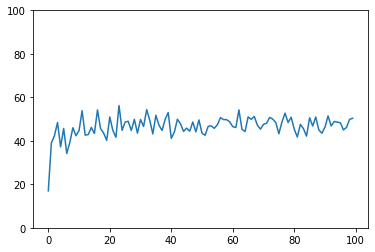

In [88]:
axes = plt.axes()
axes.set_ylim([0, 100])
plt.plot(x_2)

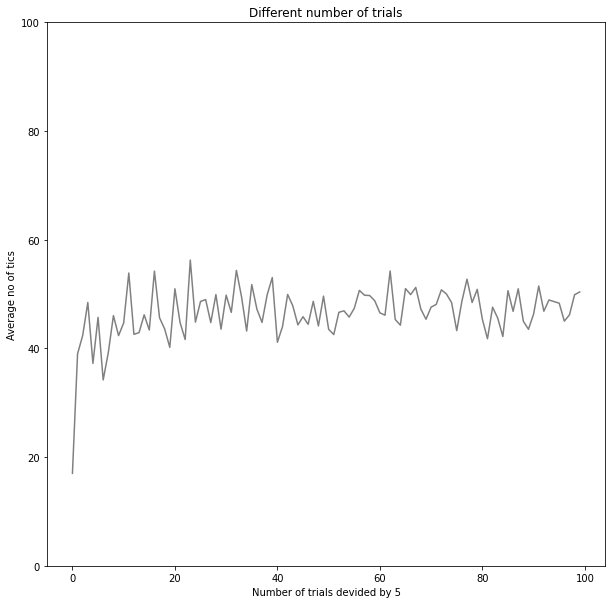

In [97]:
fig = plt.figure(figsize=(10,10))
axes = plt.axes()
axes.set_ylim([0, 100])
plt.title("Different number of trials")
plt.xlabel("Number of trials divided by 5")
plt.ylabel("Average no of tics")
plt.plot(x_2,color = "gray");

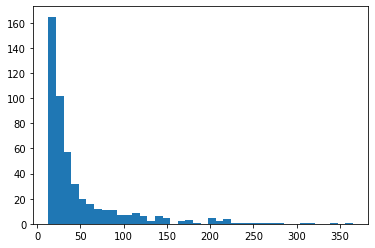

In [98]:
plt.hist(var2[-1],bins=40);

In [78]:
plt.hist(kat["pagerank"],bins = 40);

NameError: name 'kat' is not defined

## infection vizualizations

In [ ]:
G_infection = nx.DiGraph()

In [ ]:
pos = dict()
for i,j in zip(coords_name_df['ORIGIN'],coords_name_df['COORDS']):
    pos[i] = (j[0],j[1])
    G_infection.add_node(i)

In [ ]:
for i,j,k in zip(data_filtered_coord[mask]['ORIGIN'],data_filtered_coord[mask]['DEST'],data_filtered_coord[mask]['PASSENGERS']):
    G_infection.add_edge(i,j,weight=k)

In [ ]:
for node in G_infection.nodes():
    G_infection.nodes[node]['sum_weight_root'] = np.sqrt(sum([G_infection[node][i]['weight'] for i in G_infection.neighbors(node)]) + 0.001)

In [ ]:
edges = [(row['ORIGIN'], row['DEST'], {'weight': row['PASSENGERS']}) for _, row in data_filtered.iterrows()]

In [ ]:
sim1 = Simulation(edges)

In [ ]:
sim1.Graph = G_infection

In [ ]:
sets = sim1.simulate_amount_of_ticks(beta=0.05, ticks=20)

In [ ]:
for index, i in enumerate(sets):
    fig = plt.figure(figsize =(300,200))
    col_list = ['red' if node in i else 'green' for node in G_infection.nodes]
    nx.draw(G_infection,pos = pos,with_labels = True,font_color = 'white',node_size = 5000,node_color = col_list,edge_color = 'lightgray')
    plt.savefig('spread'+ str(index) +'.png')

# Martin (done by Florian) 😍🤯😤

In [ ]:
infected_nodes = {}
infected_nodes.add(random start node)
counter = 0
while counter < 500 or len(infected_nodes) <= 250:
    for nodes in infected_nodes
        if probability(node[neighbor]) > random.int(0,100):
            infected_nodes.add(node[neighbor])
    counter += 1

Longest shortest paths
redo!!!!!

In [ ]:
data1 = pd.read_csv("../Data/to_florian_dataframe_longest_paths.csv",delimiter=",")

In [ ]:
list1 = []
for i in data1['coordinates']:
    list1.append(eval(i))

In [ ]:
float_coords = []
for i in list1:
    temp = []
    for j in i:
        j_0 = eval(j[0])
        j_1 = eval(j[1])
        temp.append((j_0,j_1))
    float_coords.append(temp)

In [ ]:
float_coords = np.array(float_coords)

In [ ]:
coords = []
for i in float_coords:
    x_values = i[:,0]
    y_values = i[:,1]
    coords.append(list(zip(x_values,y_values)))
    plt.plot(y_values,x_values)
    plt.scatter(y_values,x_values)
mplleaflet.show()

In [ ]:
coords_list = []
for i in coords:
    for j in i:
        coords_list.append(j)

In [ ]:
split_coords = []
for i in range(1,len(coords_list)):
    split_coords.append(coords_list[i-1:i+1])

In [ ]:
names = []
for i in data1['path']:
    names.append(eval(i))

In [ ]:
names_list = []
for i in names:
    for j in i:
        names_list.append(j)

In [ ]:
split_names = []
for i in range(1, len(names_list)):
    split_names.append(tuple(names_list[i-1:i+1]))

Doing stuff because Martin wanted some labels 😘

In [ ]:
map1 = folium.Map()

In [ ]:
for origin,name in zip(coords_list,names_list):
        folium.Marker(location= origin ,popup = name,icon=folium.Icon(color='lightgray', icon='plane',prefix = 'fa')).add_to(map1)

In [ ]:
for i in range(len(split_coords)):
    folium.PolyLine(split_coords[i],popup = split_names[i],color = 'lightgray').add_to(map1)

In [ ]:
#map1

Degree centrality

In [ ]:
data2 = pd.read_csv('../Data/to_florian_dataframe_degree_centrality.csv')

In [ ]:
org = list(zip(data2['ORIGIN_LAT'],data2['ORIGIN_LONG']))

In [ ]:
org = np.array(org)

In [ ]:
plt.scatter(org[:,1],org[:,0])
mplleaflet.show()

Clustering coefficient

In [ ]:
data3 = pd.read_csv('../Data/to_florian_clustering_coefficient.csv')

In [ ]:
org1 = list(zip(data3['ORIGIN_LAT'],data3['ORIGIN_LONG']))

In [ ]:
org1 = pd.DataFrame(org1)

In [ ]:
org1['weight'] = data3['COEFFICIENT']

In [ ]:
plt.scatter(org1[1],org1[0])
mplleaflet.show()

In [ ]:
#heatmap

In [ ]:
map_osm = folium.Map()

In [ ]:
HeatMap(org1).add_to(map_osm);

In [ ]:
map_osm